# Using Ragas to Evaluate a RAG Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Synthetic Dataset Generation for Evaluation using Ragas
  4. Task 4: Evaluating our Pipeline with Ragas
  5. Task 6: Making Adjustments and Re-Evaluating

But first! Let's set some dependencies!

## Dependencies and API Keys:

> NOTE: Please skip the pip install commands if you are running the notebook locally.

In [51]:
#!pip install -qU ragas==0.2.10

In [52]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

We'll also need to provide our API keys.

First, OpenAI's for our LLM/embedding model combination!

In [53]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

OPTIONALLY:

We can also provide a Ragas API key - which you can sign-up for [here](https://app.ragas.io/).

In [54]:
os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [55]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [56]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31314    0 31314    0     0   396k      0 --:--:-- --:--:-- --:--:--  397k


In [57]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70286    0 70286    0     0   211k      0 --:--:-- --:--:-- --:--:--  211k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [58]:
import os

print("Files in data/:", os.listdir("data/"))

Files in data/: ['2024_llms.html', '2023_llms.html']


In [59]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader
import nltk

path = "data/"
loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [60]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [61]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/24 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [62]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wht is Llama 3.2's capabilty on iPhone?,[The rise of inference-scaling “reasoning” mod...,Llama 3.2 3B can run on an iPhone using the fr...,single_hop_specifc_query_synthesizer
1,What is the cost efficiency of using Google's ...,[but still their cheapest model) is $0.25/mTok...,"Using Google's Gemini 1.5 Flash 8B, the cost t...",single_hop_specifc_query_synthesizer
2,Wht is the WebRTC API?,[which they managed to ship the day before Cha...,"The WebRTC API, announced by OpenAI in Decembe...",single_hop_specifc_query_synthesizer
3,Wht is the role of ASML in the context of LLM-...,[for much of the work behind Claude’s Characte...,"A prompt without the evals, models, and especi...",single_hop_specifc_query_synthesizer
4,What are some AI breakthroughs in 2023 related...,[<1-hop>\n\nWe don’t yet know how to build GPT...,"In 2023, significant breakthroughs in AI, part...",multi_hop_abstract_query_synthesizer
5,What were the major AI breakthroughs in 2023 r...,[<1-hop>\n\nWe don’t yet know how to build GPT...,"In 2023, Large Language Models (LLMs) experien...",multi_hop_abstract_query_synthesizer
6,What were the major AI breakthroughs in 2023 r...,[<1-hop>\n\nWe don’t yet know how to build GPT...,"In 2023, Large Language Models (LLMs) experien...",multi_hop_abstract_query_synthesizer
7,How do the ethics of AI and the concept of 'sl...,[<1-hop>\n\nWe don’t yet know how to build GPT...,The ethics of AI are described as 'diabolicall...,multi_hop_abstract_query_synthesizer
8,How has the development of prompt-driven app g...,[<1-hop>\n\nwhich they managed to ship the day...,The development of prompt-driven app generatio...,multi_hop_specific_query_synthesizer
9,How does the efficiency and cost of training m...,"[<1-hop>\n\nMeta’s Llama series, Llama 3.1 405...",The efficiency and cost of training models lik...,multi_hop_specific_query_synthesizer


#### OPTIONAL:

If you've provided your Ragas API key - you can use this web interface to look at the created data!

In [63]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/97fa5ecc-f56c-4ad7-b942-2407df167e7f


'https://app.ragas.io/dashboard/alignment/testset/97fa5ecc-f56c-4ad7-b942-2407df167e7f'

## LangChain RAG

Now we'll construct our LangChain RAG, which we will be evaluating using the above created test data!

### R - Retrieval

Let's start with building our retrieval pipeline, which will involve loading the same data we used to create our synthetic test set above.

> NOTE: We need to use the same data - as our test set is specifically designed for this data.

In [64]:
path = "data/"
loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)
docs = loader.load()

Now that we have our data loaded, let's split it into chunks!

In [65]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

79

#### ❓ Question: 

What is the purpose of the `chunk_overlap` parameter in the `RecursiveCharacterTextSplitter`? Ensure context continuity, by overlpaing chunks it helps retain context when chunks are processed.

Next up, we'll need to provide an embedding model that we can use to construct our vector store.

In [66]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store.

In [67]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ai_across_years",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_across_years",
    embedding=embeddings,
)

We can now add our documents to our vector store.

In [68]:
_ = vector_store.add_documents(documents=split_documents)

Let's define our retriever.

In [69]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Now we can produce a node for retrieval!

In [70]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Augmented

Let's create a simple RAG prompt!

In [71]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

We'll also need an LLM to generate responses - we'll use `gpt-4o-mini` to avoid using the same model as our judge model.

In [72]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Then we can create a `generate` node!

In [73]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [84]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from IPython.display import Image, display

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

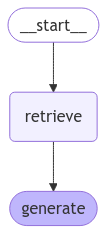

In [85]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's do a test to make sure it's doing what we'd expect.

In [76]:
response = graph.invoke({"question" : "How are LLM agents useful?"})

In [77]:
response["response"]

'LLM agents are useful in several ways:\n\n1. **Task Automation**: They can perform tasks on behalf of users, acting as AI systems that can execute commands or processes without direct human intervention.\n\n2. **Programming Assistance**: LLMs have proven to be highly effective at writing code. They can help developers by generating code snippets, debugging, and providing solutions to programming problems, which is facilitated by the simpler grammar rules of programming languages compared to natural languages.\n\n3. **Productivity Enhancement**: Individuals can use LLMs to improve their productivity in various personal and professional tasks. They can assist with summarization, translation, information extraction, and more, contributing to a boost in quality of life for those who learn to use them effectively.\n\n4. **Entertainment and Creativity**: LLMs can generate creative content, provide entertainment, and even assist in educational contexts, such as helping with homework.\n\nOver

## Evaluating the App with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [78]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [79]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Wht is Llama 3.2's capabilty on iPhone?,[Meta’s Llama 3.2 models deserve a special men...,[The rise of inference-scaling “reasoning” mod...,"Llama 3.2, particularly the 3B size model, is ...",Llama 3.2 3B can run on an iPhone using the fr...,single_hop_specifc_query_synthesizer
1,What is the cost efficiency of using Google's ...,[Each photo would need 260 input tokens and ar...,[but still their cheapest model) is $0.25/mTok...,The cost efficiency of using Google's Gemini 1...,"Using Google's Gemini 1.5 Flash 8B, the cost t...",single_hop_specifc_query_synthesizer
2,Wht is the WebRTC API?,[These abilities are just a few weeks old at t...,[which they managed to ship the day before Cha...,The WebRTC API is a new API introduced by Open...,"The WebRTC API, announced by OpenAI in Decembe...",single_hop_specifc_query_synthesizer
3,Wht is the role of ASML in the context of LLM-...,[Here’s the sequel to this post: Things we lea...,[for much of the work behind Claude’s Characte...,The provided context does not mention ASML or ...,"A prompt without the evals, models, and especi...",single_hop_specifc_query_synthesizer
4,What are some AI breakthroughs in 2023 related...,[Stuff we figured out about AI in 2023\n\n\n\n...,[<1-hop>\n\nWe don’t yet know how to build GPT...,"In 2023, several breakthroughs related to Larg...","In 2023, significant breakthroughs in AI, part...",multi_hop_abstract_query_synthesizer
5,What were the major AI breakthroughs in 2023 r...,[Stuff we figured out about AI in 2023\n\n\n\n...,[<1-hop>\n\nWe don’t yet know how to build GPT...,"In 2023, several major breakthroughs were made...","In 2023, Large Language Models (LLMs) experien...",multi_hop_abstract_query_synthesizer
6,What were the major AI breakthroughs in 2023 r...,[Stuff we figured out about AI in 2023\n\n\n\n...,[<1-hop>\n\nWe don’t yet know how to build GPT...,"In 2023, significant breakthroughs in Large La...","In 2023, Large Language Models (LLMs) experien...",multi_hop_abstract_query_synthesizer
7,How do the ethics of AI and the concept of 'sl...,[Watching in real time as “slop” becomes a ter...,[<1-hop>\n\nWe don’t yet know how to build GPT...,The ethics of AI and the concept of 'slop' are...,The ethics of AI are described as 'diabolicall...,multi_hop_abstract_query_synthesizer
8,How has the development of prompt-driven app g...,[A lot of people are excited about AI agents—a...,[<1-hop>\n\nwhich they managed to ship the day...,The development of prompt-driven app generatio...,The development of prompt-driven app generatio...,multi_hop_specific_query_synthesizer
9,How does the efficiency and cost of training m...,"[Likewise, training. DeepSeek v3 training for ...","[<1-hop>\n\nMeta’s Llama series, Llama 3.1 405...",The efficiency and cost of training models lik...,The efficiency and cost of training models lik...,multi_hop_specific_query_synthesizer


Then we can convert that table into a `EvaluationDataset` which will make the process of evaluation smoother.

In [80]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.

In [81]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

Next up - we simply evaluate on our desired metrics!

In [82]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 0.5701, 'faithfulness': 0.7871, 'factual_correctness': 0.5825, 'answer_relevancy': 0.8633, 'context_entity_recall': 0.5084, 'noise_sensitivity_relevant': 0.2032}

## Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!

> NOTE: This will be using Cohere's Rerank model (which was updated fairly [recently](https://docs.cohere.com/v2/changelog/rerank-v3.5)) - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)

In [83]:
os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")

KeyboardInterrupt: Interrupted by user

In [ ]:
#!pip install -qU cohere langchain_cohere


We'll first set our retriever to return more documents, which will allow us to take advantage of the reranking.

In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

Reranking, or contextual compression, is a technique that uses a reranker to compress the retrieved documents into a smaller set of documents.

This is essentially a slower, more accurate form of semantic similarity that we use on a smaller subset of our documents.

In [ ]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5")
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

We can simply rebuild our graph with the new retriever!

In [ ]:
class State(TypedDict):
  question: str
  context: List[Document]
  response: str

graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

In [ ]:
response = graph.invoke({"question" : "How are LLM agents useful?"})
response["response"]

'LLM agents are considered useful for several reasons, primarily their ability to enhance productivity and assist with various tasks. They can:\n\n1. **Answer Questions**: LLMs can provide information and clarify doubts on a wide range of topics.\n2. **Summarize Documents**: They can condense large amounts of information into more digestible formats.\n3. **Translate Languages**: LLMs can translate text from one language to another, facilitating communication.\n4. **Extract Information**: They can sift through text to find specific data or insights.\n5. **Write Code**: LLMs have shown strong capabilities in generating and writing code, which is simpler for them compared to natural languages.\n\nAdditionally, individuals who learn to use LLMs effectively can experience a significant boost in their quality of life, as these models can help with tasks such as homework, content creation, and more. However, there are challenges, particularly regarding their gullibility, which affects their d

In [ ]:
import time

for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
  time.sleep(2) # To try to avoid rate limiting.

In [50]:
result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[29]: TimeoutError()


{'context_recall': 0.6238, 'faithfulness': 0.6851, 'factual_correctness': 0.4558, 'answer_relevancy': 0.8029, 'context_entity_recall': 0.4336, 'noise_sensitivity_relevant': 0.1700}

#### ❓ Question: 

Which system performed better, on what metrics, and why?

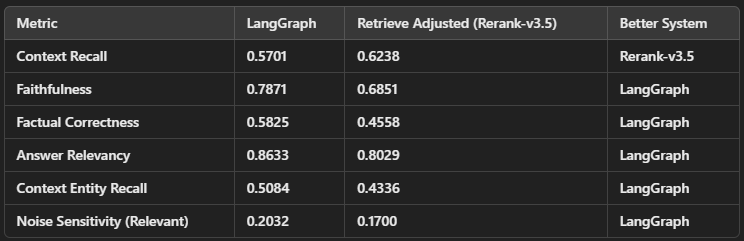

 - LangGraph is the better system overall because it produces more faithful, factually correct, and relevant responses while maintaining strong retrieval and reducing hallucinations.
 
 - Retrieve Adjusted (Rerank-v3.5) is better at retrieving more relevant context but struggles with faithfulness and factual correctness, making it less reliable in a real-world setting.